#Text Classification using LSTM Model

## Data preprocessing

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import text_hammer as th
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [ ]:
df['len'] = list(map(lambda x: len(str(x).split(' ')),df['Sentence']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,positive,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11
2,"For the last quarter of 2010 , Componenta 's n...",positive,39
3,According to the Finnish-Russian Chamber of Co...,neutral,20
4,The Swedish buyout firm has sold its remaining...,neutral,23


In [ ]:
mapdf = {'positive':0,'negative':1,'neutral':2}
df['Sentiment'] = list(map(lambda x:mapdf[x],df['Sentiment']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,0,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,11
2,"For the last quarter of 2010 , Componenta 's n...",0,39
3,According to the Finnish-Russian Chamber of Co...,2,20
4,The Swedish buyout firm has sold its remaining...,2,23


In [ ]:
print(df['Sentiment'].corr(df['len']))

0.10137114484667775


In [ ]:
sentences = df['Sentence'].copy()[:]
sentences = sentences.to_list()
sentences = list(map(lambda x: x.lower(),sentences))
sentences = list(map(lambda x: th.cont_exp(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_html_tags(x),sentences))
sentences = list(map(lambda x: th.remove_stopwords(x),sentences))
sentences = list(map(lambda x: th.remove_special_chars(x),sentences))
sentences = list(map(lambda x: th.remove_accented_chars(x),sentences))
sentences = list(map(lambda x: th.make_base(x),sentences))

In [ ]:
sentences[:3]

['geosolution technology leverage benefon global positioning system solution provide location base search technology community platform location relevant multimedia content new powerful commercial model',
 'esi low 150 250 bk real possibility',
 'quarter 2010 componenta net sale double eur131 m eur76 m period year early move zero pretax profit pretax loss eur7 m']

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.all_utils import to_categorical
y = to_categorical(df['Sentiment'])
x = sentences.copy()
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

## Vectorization

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 12000 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([pd.Series(X_train), pd.Series(X_test)], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=81,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 81, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(4089, 81) (1753, 81)


## Model Building 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Bidirectional,Embedding,Dropout

In [ ]:
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words,
                          output_dim = 100,
                          input_length= X_train_pad.shape[1]))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(100,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(200,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(100,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dropout(0.2))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dropout(0.2))
lstm.add(Dense(10,activation='tanh'))
lstm.add(Dense(3,activation='softmax'))

In [ ]:
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 81, 100)           1200000   
                                                                 
 dropout_6 (Dropout)         (None, 81, 100)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 81, 200)          160800    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 81, 200)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 81, 400)          641600    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 81, 400)          

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

## Model Fitting

In [ ]:
lstm_history = lstm.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.9757 - accuracy: 0.5412
Epoch 00001: val_accuracy improved from -inf to 0.63776, saving model to .\model.h5
64/64 [==============================] - 15s 131ms/step - loss: 0.9757 - accuracy: 0.5412 - val_loss: 0.8713 - val_accuracy: 0.6378
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.7386
Epoch 00002: val_accuracy improved from 0.63776 to 0.66343, saving model to .\model.h5
64/64 [==============================] - 7s 103ms/step - loss: 0.6482 - accuracy: 0.7386 - val_loss: 0.7741 - val_accuracy: 0.6634
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8459
Epoch 00003: val_accuracy improved from 0.66343 to 0.68568, saving model to .\model.h5
64/64 [==============================] - 7s 103ms/step - loss: 0.3840 - accuracy: 0.8459 - val_loss: 0.8131 - val_accuracy: 0.6857
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss

## Model Visual Analysis

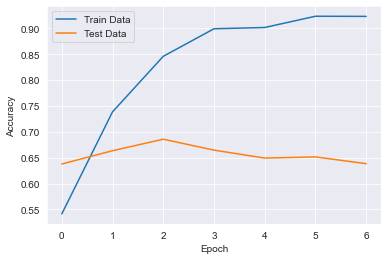

In [ ]:
plt.plot(lstm_history.history['accuracy'], label='Train Data')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

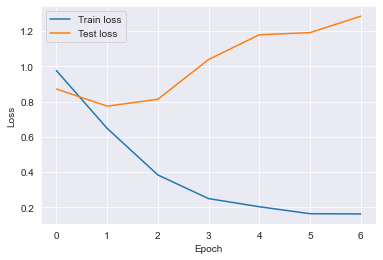

In [ ]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## Model Summary

In [ ]:
from sklearn.metrics import classification_report
predictions = lstm.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.71      0.63      0.67       556
    negative       0.29      0.32      0.30       258
     neutral       0.71      0.73      0.72       939

    accuracy                           0.64      1753
   macro avg       0.57      0.56      0.56      1753
weighted avg       0.65      0.64      0.64      1753

